# **Cost-effectiveness analysis - StaDiOS**

* Install the dependencies to be used in the analysis

In [ ]:
# SPARQL endpoint interface
%pip install sparqlwrapper
from SPARQLWrapper import SPARQLWrapper, JSON

# Pandas dependencies
%pip install pandas
import pandas as pd
from pandas import json_normalize

# Export dependencies and file modification
import json
#from google.colab import files
#from IPython.display import FileLink

# Graphical representations and interaction options
%pip install matplotlib
#%pip install itables
%pip install pydot
import matplotlib.pyplot as plt
import pydot
#from itables import show
from IPython.display import Image, display

#Combinatorics for branch probabilities in cost-effectiveness analysis
%pip install itertools
import itertools
from itertools import product

* Standard query to start creating cost-effectiveness analysis.

In [17]:
def generate_query(sparql_query, endpoint):

    # Create the connection to the endpoint
    sparql = SPARQLWrapper(endpoint, agent="SparqlWrapper - StaDiOS analysis")  
    sparql.setQuery(sparql_query)
    sparql.setReturnFormat(JSON)

    # Ask for the result in JSON format
    result = sparql.query().convert()
    return json_normalize(result["results"]["bindings"])

# Sparql ontology access point
end_point = "http://localhost:3030/StaDiOS/sparql"

# Standard query to enable analysis
query = """

PREFIX st: <http://ns.inria.fr/sparql-template/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX std: <http://www.semanticweb.org/storh/ontologies/2022/11/StaDiOS#>

SELECT ?disease ?intervention ?interventionKind ?populationKind ?populationAverageAge ?populationUtilityValue ?detectionStrategy ?sensitivity ?specificity ?prevalenceAtBirth ?detectionStrategyAmount ?detectionStrategyCurrency ?detectionStrategyYear ?development ?lifeExpectancy ?manifestation ?manifestationProbability ?manifestationInitialAmount ?manifestationAnnualAmount ?manifestationCurrency ?manifestationYear ?utilityValue ?utilityKind ?followUpStrategy ?followUpAmount ?followUpCurrency ?followUpYear ?treatmentStrategy ?treatmentStrategyAmount ?treatmentStrategyCurrency ?treatmentYear
WHERE {
    ?disease std:hasInterventions ?intervention;
             std:hasPrevalenceAtBirth ?prevalenceAtBirth;
             std:hasDiseaseDevelopments ?development .

    ?intervention std:hasInterventionDetectionStrategy ?detectionStrategy;
                  std:hasInterventionFollowUpStrategy ?followUpStrategy;
                  std:hasInterventionTreatmentStrategy ?treatmentStrategy;
                  std:hasInterventionKind ?interventionKind;
  				  std:hasInterventionPopulation ?interventionPopulation.
    ?interventionPopulation std:hasPopulationKind ?populationKind;
                            std:hasAverageAge ?populationAverageAge;
                            std:hasLifeExpectancy ?lifeExpectancy;
                            std:hasStudyIdentifier ?studyIdentifier;
                            std:hasPopulationUtility ?populationUtility .
    ?populationUtility std:hasValue ?populationUtilityValue . 

    ?detectionStrategy std:hasDetectionStrategyCost ?detectionStrategyCost;
                       std:hasSpecificity ?specificity;
                       std:hasSensitivity ?sensitivity.
    ?detectionStrategyCost std:hasAmount ?detectionStrategyAmount;
                           std:hasCurrency ?detectionStrategyCurrency;
                           std:hasYear ?detectionStrategyYear .

    ?followUpStrategy std:hasFollowUpStrategyCost ?followUpStrategyCost .
    ?followUpStrategyCost std:hasAmount ?followUpAmount;
                          std:hasCurrency ?followUpCurrency;
                          std:hasYear ?followUpYear.

    ?treatmentStrategy std:hasTreatmentStrategyCost ?treatmentStrategyCost .
    ?treatmentStrategyCost std:hasAmount ?treatmentStrategyAmount;
                           std:hasCurrency ?treatmentStrategyCurrency;
                           std:hasYear ?treatmentYear.

    ?development std:hasDevelopmentManifestations ?manifestation .

    ?manifestation std:hasManifestationTreatmentStrategy ?treatmentStrategy;
                   std:hasManifestationCost ?manifestationCost;
                   std:hasUtility ?utility;
                   std:hasProbability ?manifestationProbability .
    ?manifestationCost std:hasAmount ?manifestationAnnualAmount;
                       std:hasInitialAmount ?manifestationInitialAmount;
                       std:hasCurrency ?manifestationCurrency;
                       std:hasYear ?manifestationYear;
                       std:hasStudyIdentifier ?studyIdentifier .
                       
    ?utility std:hasValue ?utilityValue;
             std:hasUtilityKind ?utilityKind;
             std:hasStudyIdentifier ?studyIdentifier .

    FILTER(?disease = std:PBD_ProfoundBiotinidaseDeficiency && ?development = std:PBD_NaturalDevelopment 
    && ?followUpStrategy = std:PBD_FollowUpStrategy && ?treatmentStrategy = std:PBD_BiotinTreatmentStrategy) .
    FILTER (STR(?studyIdentifier) = "PBD_001") .
}

"""

* We obtain a query in JSON format and load it into a Dataframe for easy manipulation.
* We specify some key numeric columns for the transformation of the initial dataframe

In [18]:
# Query
query_result = generate_query(query, end_point)

# Simplify column names and data types
pd.set_option('display.max_columns', None)
simplified_df = query_result.filter(regex='value')
simplified_df = simplified_df.rename(columns = lambda col: col.replace(".value", ""))
simplified_df = simplified_df.apply(lambda row: row.replace({'http://www.semanticweb.org/storh/ontologies/2022/11/StaDiOS#':''}, regex=True))

simplified_df['sensitivity'] = simplified_df['sensitivity'].apply(pd.to_numeric)
simplified_df['specificity'] = simplified_df['specificity'].apply(pd.to_numeric)
simplified_df['manifestationProbability'] = simplified_df['manifestationProbability'].apply(pd.to_numeric)
simplified_df['prevalenceAtBirth'] = simplified_df['prevalenceAtBirth'].apply(pd.to_numeric)

simplified_df

,disease,intervention,interventionKind,populationKind,populationAverageAge,populationUtilityValue,detectionStrategy,sensitivity,specificity,prevalenceAtBirth,detectionStrategyAmount,detectionStrategyCurrency,detectionStrategyYear,development,lifeExpectancy,manifestation,manifestationProbability,manifestationInitialAmount,manifestationAnnualAmount,manifestationCurrency,manifestationYear,utilityValue,utilityKind,followUpStrategy,followUpAmount,followUpCurrency,followUpYear,treatmentStrategy,treatmentStrategyAmount,treatmentStrategyCurrency,treatmentYear
0,PBD_ProfoundBiotinidaseDeficiency,PBD_InterventionNoScreening,DIAGNOSIS,NEONATAL,1.0,0.8861,PBD_ClinicalDiagnosisStrategy,1.000000,1.000000,0.000015,509.65,Euro,2013,PBD_NaturalDevelopment,82.272854,PBD_SkinProblemsManifestation,0.410,3665.56,0.0,Euro,2013,0.8861,UTILITY,PBD_FollowUpStrategy,616.75672,Euro,2013,PBD_BiotinTreatmentStrategy,66.2475,Euro,2013
1,PBD_ProfoundBiotinidaseDeficiency,PBD_InterventionNoScreening,DIAGNOSIS,NEONATAL,1.0,0.8861,PBD_ClinicalDiagnosisStrategy,1.000000,1.000000,0.000015,509.65,Euro,2013,PBD_NaturalDevelopment,82.272854,PBD_HypotoniaManifestation,0.457,3665.56,0.0,Euro,2013,0.8861,UTILITY,PBD_FollowUpStrategy,616.75672,Euro,2013,PBD_BiotinTreatmentStrategy,66.2475,Euro,2013
2,PBD_ProfoundBiotinidaseDeficiency,PBD_InterventionNoScreening,DIAGNOSIS,NEONATAL,1.0,0.8861,PBD_ClinicalDiagnosisStrategy,1.000000,1.000000,0.000015,509.65,Euro,2013,PBD_NaturalDevelopment,82.272854,PBD_MentalDelayManifestation,0.557,16824.19,217.74,Euro,2013,0.8161,UTILITY,PBD_FollowUpStrategy,616.75672,Euro,2013,PBD_BiotinTreatmentStrategy,66.2475,Euro,2013
3,PBD_ProfoundBiotinidaseDeficiency,PBD_InterventionNoScreening,DIAGNOSIS,NEONATAL,1.0,0.8861,PBD_ClinicalDiagnosisStrategy,1.000000,1.000000,0.000015,509.65,Euro,2013,PBD_NaturalDevelopment,82.272854,PBD_SeizureManifestation,0.564,3665.56,0.0,Euro,2013,0.8461,UTILITY,PBD_FollowUpStrategy,616.75672,Euro,2013,PBD_BiotinTreatmentStrategy,66.2475,Euro,2013
4,PBD_ProfoundBiotinidaseDeficiency,PBD_InterventionNoScreening,DIAGNOSIS,NEONATAL,1.0,0.8861,PBD_ClinicalDiagnosisStrategy,1.000000,1.000000,0.000015,509.65,Euro,2013,PBD_NaturalDevelopment,82.272854,PBD_VisionLossManifestation,0.175,10155.44,121.86,Euro,2013,0.8861,UTILITY,PBD_FollowUpStrategy,616.75672,Euro,2013,PBD_BiotinTreatmentStrategy,66.2475,Euro,2013
5,PBD_ProfoundBiotinidaseDeficiency,PBD_InterventionNoScreening,DIAGNOSIS,NEONATAL,1.0,0.8861,PBD_ClinicalDiagnosisStrategy,1.000000,1.000000,0.000015,509.65,Euro,2013,PBD_NaturalDevelopment,82.272854,PBD_HearingProblemsManifestation,0.515,43778.75,155.14,Euro,2013,0.8761,UTILITY,PBD_FollowUpStrategy,616.75672,Euro,2013,PBD_BiotinTreatmentStrategy,66.2475,Euro,2013
6,PBD_ProfoundBiotinidaseDeficiency,PBD_InterventionScreening,SCREENING,NEONATAL,1.0,0.8861,PBD_ScreeningDetectionStrategy,0.999935,0.999935,0.000015,0.89,Euro,2013,PBD_NaturalDevelopment,82.272854,PBD_SkinProblemsManifestation,0.410,3665.56,0.0,Euro,2013,0.8861,UTILITY,PBD_FollowUpStrategy,616.75672,Euro,2013,PBD_BiotinTreatmentStrategy,66.2475,Euro,2013
7,PBD_ProfoundBiotinidaseDeficiency,PBD_InterventionScreening,SCREENING,NEONATAL,1.0,0.8861,PBD_ScreeningDetectionStrategy,0.999935,0.999935,0.000015,0.89,Euro,2013,PBD_NaturalDevelopment,82.272854,PBD_HypotoniaManifestation,0.457,3665.56,0.0,Euro,2013,0.8861,UTILITY,PBD_FollowUpStrategy,616.75672,Euro,2013,PBD_BiotinTreatmentStrategy,66.2475,Euro,2013
8,PBD_ProfoundBiotinidaseDeficiency,PBD_InterventionScreening,SCREENING,NEONATAL,1.0,0.8861,PBD_ScreeningDetectionStrategy,0.999935,0.999935,0.000015,0.89,Euro,2013,PBD_NaturalDevelopment,82.272854,PBD_MentalDelayManifestation,0.557,16824.19,217.74,Euro,2013,0.8161,UTILITY,PBD_FollowUpStrategy,616.75672,Euro,2013,PBD_BiotinTreatmentStrategy,66.2475,Euro,2013
9,PBD_ProfoundBiotinidaseDeficiency,PBD_InterventionScreening,SCREENING,NEONATAL,1.0,0.8861,PBD_ScreeningDetectionStrategy,0.999935,0.999935,0.000015,0.89,Euro,2013,PBD_NaturalDevelopment,82.272854,

* We separate the dataframe into subtables according to the column of intervention

In [19]:
interventions = simplified_df.intervention.unique()
grouped_interventions = simplified_df.groupby(simplified_df.intervention)
interventions_df = list()

for intervention in interventions:
    interventions_df.append(grouped_interventions.get_group(intervention))

* Depending on the type of intervention, dataframes may require some transformation.

In [20]:
# Screening detection probability values - We assume that there is no guaranteed hit
def adjust_detection_probability(dataframe):

    dataframe.loc[dataframe['DetectionCase'] == 'True Positive', 'DetectionProbability'] = dataframe['sensitivity']*dataframe['prevalenceAtBirth']
    dataframe.loc[dataframe['DetectionCase'] == 'False Positive', 'DetectionProbability'] = (1-dataframe['sensitivity'])*(1-dataframe['prevalenceAtBirth'])
    dataframe.loc[dataframe['DetectionCase'] == 'True Negative', 'DetectionProbability'] = dataframe['specificity']*(1-dataframe['prevalenceAtBirth'])
    dataframe.loc[dataframe['DetectionCase'] == 'False Negative', 'DetectionProbability'] = (1-dataframe['specificity'])*(dataframe['prevalenceAtBirth'])

    return dataframe

# Screening configuration - True positive, False positive, True negative - False negative data is obtained from StaDiOS
def screening_simulation(dataframe):
    
    dataframe.insert(6, 'hasDisease', 'Disease')
    dataframe.insert(7, 'DetectionCase', 'False Negative')
    dataframe.insert(12, 'DetectionProbability', 1.0)
    dataframe = dataframe.reset_index(drop=True)

    # True positive configuration - No manifestation, only detection and treatment costs
    dataframe = pd.concat([dataframe, dataframe[-1:]]).reset_index(drop=True)
    dataframe.loc[dataframe.index[-1],['hasDisease', 'DetectionCase','DetectionProbability', 'manifestation', 'manifestationProbability',	
                             'manifestationInitialAmount', 'manifestationAnnualAmount', 'utilityValue']] = \
        ['Disease', 'True Positive', 1.0, 'NONE', 0.0, 0.0, 0.0, 1.0]
    
    # False positive configuration - No manifestation, only detection costs
    dataframe = pd.concat([dataframe, dataframe[-1:]]).reset_index(drop=True)
    dataframe.loc[dataframe.index[-1],['hasDisease', 'DetectionCase','DetectionProbability', 'manifestation', 'manifestationProbability',	
                             'manifestationInitialAmount', 'manifestationAnnualAmount', 'utilityValue', 'followUpAmount',
                             'treatmentStrategyAmount']] = \
        ['No Disease', 'False Positive', 1.0, 'NONE', 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

    # True negative configuration - No manifestation, only detection costs
    dataframe = pd.concat([dataframe, dataframe[-1:]]).reset_index(drop=True)
    dataframe.loc[dataframe.index[-1],['hasDisease', 'DetectionCase','DetectionProbability', 'manifestation', 'manifestationProbability',	
                             'manifestationInitialAmount', 'manifestationAnnualAmount', 'utilityValue', 'followUpAmount',
                             'treatmentStrategyAmount']] = \
        ['No Disease', 'True Negative', 1.0, 'NONE', 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
    
    return adjust_detection_probability(dataframe)

# Diagnosis and general configuration - We assume that they always detect true positives.
def standard_simulation(dataframe):
    dataframe.insert(6, 'hasDisease', 'Disease')
    dataframe.insert(7, 'DetectionCase', 'NONE')
    dataframe.insert(12, 'DetectionProbability', 1.0)
    dataframe = dataframe.reset_index(drop=True)
    
    dataframe = pd.concat([dataframe, dataframe[-1:]]).reset_index(drop=True)
    dataframe.loc[dataframe.index[-1],['hasDisease', 'DetectionCase','DetectionProbability', 'manifestation', 'manifestationProbability',	
                             'manifestationInitialAmount', 'manifestationAnnualAmount', 'utilityValue', 'followUpAmount',
                             'treatmentStrategyAmount']] = \
        ['No Disease', 'NONE', 1.0, 'NONE', 0.0, 0.0, 0.0, 1.0, 0.0, 0.0 ]
    
    dataframe.loc[dataframe['hasDisease'] == 'Disease', 'DetectionProbability'] = dataframe['prevalenceAtBirth']
    dataframe.loc[dataframe['hasDisease'] == 'No Disease', 'DetectionProbability'] = 1-dataframe['prevalenceAtBirth']
    
    return dataframe

# We must calculate the combinations between manifestations to obtain the real probability of each event.
def adjust_branch_probability(dataframe):

    dataframe['Branch Probability'] = 0.0
    ref_column = 'manifestation'

    # Get the unique values in the reference column
    ref_values = dataframe[ref_column].unique()
    ref_values = [i for i in ref_values if i != 'NONE']

    # Generate all combinations of "Yes" and "No" values
    combos = list(product(['Yes', 'No'], repeat=len(ref_values)))
    new_df = pd.DataFrame(columns=[ref_column] + [f'{ref_values[i]}' for i in range(len(ref_values))])

    # We generate dataframe with the possible combinations of manifestations
    for i, combo in enumerate(combos):
        new_row = {ref_column: dataframe['detectionStrategy'].unique()}
        for j, value in enumerate(combo):
            new_row[f'{ref_values[j]}'] = value
        new_df.loc[i] = new_row
    # We replace the "Yes" and "No" values by the probability of each manifestation
    for column in new_df.columns[1:]:
        row = dataframe.loc[dataframe[ref_column] == column]
        new_df.loc[new_df[column] == 'Yes', column] = row['manifestationProbability'].values[0]
        new_df.loc[new_df[column] == 'No', column] = 1-row['manifestationProbability'].values[0]
        
    # We add a column with the real probability of each combination of manifestations
    new_df['Probability'] = new_df.iloc[:, 1:].apply(lambda x: x.prod(), axis=1)
    if (new_df['Probability'].sum() != 1.0):
        raise Exception('Incorrect probabilities included - Not within 0-1 range')
    # Sum of the absolute probabilities of manifestations 
    proportion_sum = dataframe['manifestationProbability'].sum()
    
    # For each combination associated with a manifestation we multiply its actual 
    # probability by the probability of detection. We add them all together and obtain 
    # the absolute probability of each manifestation.
    for column in new_df.iloc[:, 1:-1]:
        row = dataframe.loc[dataframe[ref_column] == column].squeeze()

        manifestation_prob = row['manifestationProbability']

        sum = new_df.loc[new_df[column] == manifestation_prob, 'Probability'].sum()
        dataframe.loc[dataframe['manifestation'] == column, 'Branch Probability'] = (dataframe['DetectionProbability']*sum)/proportion_sum
        
    return dataframe 

* We apply the appropriate transformation to each type of intervention analyzed.
* As we include more interventions, this section should be expanded and modularized.

In [21]:
for i in range(len(interventions_df)):

    if 'SCREENING' in interventions_df[i]['interventionKind'].unique()\
    and 'NEONATAL' in interventions_df[i]['populationKind'].unique():
        interventions_df[i] = screening_simulation(interventions_df[i])
    else:
        interventions_df[i] = standard_simulation(interventions_df[i])
    interventions_df[i] = adjust_branch_probability(interventions_df[i])

* We should update costs according to the Spanish Consumer Price Index (CPI). 
* We use the values of CPI in January for each year.
* As we add more studies, other parameters should be added.

In [28]:
LAST_YEAR = 2023
GENERAL_INDEX = [69.53, 72.111, 73.773, 76.046, 79.234, 81.129, 84.598, 85.281, 86.158, 88.975, 90.753, 93.188, 93.373, 92.141, 91.876, 94.609, 95.153, 96.085, 97.139, 97.583, 103.567, 109.67]
HEALTHCARE_INDEX = [86.313, 88.385, 90.115, 90.337, 90.946, 92.417, 90.668, 90.732, 89.542, 88.267, 85.699, 96.032, 97.271, 97.175, 96.828, 97.551, 97.848, 98.694, 99.149, 99.62, 100.5]
FIRST_YEAR = LAST_YEAR - len(GENERAL_INDEX) + 1

def update_cost(cost, original_year, new_year, use_general_index):

    ipc = []

    if (original_year == new_year):
         return cost
    elif (original_year > LAST_YEAR | original_year < FIRST_YEAR):
        raise Exception('Parameter out of range')
    elif (new_year > LAST_YEAR | new_year < FIRST_YEAR):
        raise Exception('Parameter out of range')
    
    if use_general_index:
        ipc = GENERAL_INDEX
    else:
        ipc = HEALTHCARE_INDEX
    
    original_ipc = ipc[original_year - FIRST_YEAR]
    new_ipc = ipc[new_year - FIRST_YEAR]
    return cost * round(1000 * new_ipc / original_ipc) / 1000.0

# We must adjust the main costs of our analysis
def update_dataframe_costs(dataframe):

    dataframe['detectionStrategyAmount'] = dataframe.apply(lambda row: update_cost(row['detectionStrategyAmount'], \
                                            row['detectionStrategyYear'], LAST_YEAR, True), axis=1)
    
    dataframe['manifestationInitialAmount'] = dataframe.apply(lambda row: update_cost(row['manifestationInitialAmount'], \
                                            row['manifestationYear'], LAST_YEAR, True), axis=1)
    dataframe['manifestationAnnualAmount'] = dataframe.apply(lambda row: update_cost(row['manifestationAnnualAmount'], \
                                            row['manifestationYear'], LAST_YEAR, True), axis=1)
    
    dataframe['followUpAmount'] = dataframe.apply(lambda row: update_cost(row['followUpAmount'], \
                                            row['followUpYear'], LAST_YEAR, True), axis=1)
    
    dataframe['treatmentStrategyAmount'] = dataframe.apply(lambda row: update_cost(row['treatmentStrategyAmount'], \
                                            row['treatmentYear'], LAST_YEAR, True), axis=1)
    
    diagnosis_cost = max(dataframe.loc[dataframe['interventionKind'] == 'DIAGNOSIS', 'detectionStrategyAmount'].unique())
    screening_cost = min(dataframe.loc[dataframe['interventionKind'] == 'SCREENING', 'detectionStrategyAmount'].unique())
    # When screening is positive, a diagnostic test is needed to confirm the disease.
    dataframe.loc[dataframe["DetectionCase"] == "True Positive", "detectionStrategyAmount"] += diagnosis_cost
    dataframe.loc[dataframe["DetectionCase"] == "False Positive", "detectionStrategyAmount"] += diagnosis_cost
    # When diagnosis is positive, a screening test is needed too.
    dataframe.loc[(dataframe['interventionKind'] == "DIAGNOSIS") 
                  & (dataframe['hasDisease'] == 'Disease'), 'detectionStrategyAmount'] += screening_cost
    # These subjects will not be subjected to a diagnostic test, so they do not have their costs.
    dataframe.loc[(dataframe['interventionKind'] == "DIAGNOSIS") 
                  & (dataframe['hasDisease'] == 'No Disease'), 'detectionStrategyAmount'] = 0.0
    
    return dataframe

* We obtain a dataframe with the cost-effectiveness analysis.

In [29]:
# It is convenient to say which parameters we want to treat as numerical parameters.
numeric_params = ['populationAverageAge', 'populationUtilityValue',  'DetectionProbability','detectionStrategyAmount','lifeExpectancy',
                     'manifestationProbability', 'manifestationInitialAmount', 'manifestationAnnualAmount', 
                     'utilityValue', 'followUpAmount', 'treatmentStrategyAmount', 'detectionStrategyYear', 
                     'manifestationYear', 'followUpYear', 'treatmentYear', 'Branch Probability']

# Full analysis table - Has some extra but not crucial information
full_dataframe = pd.DataFrame()

# We unify the sub-tables of the analysis of each disease-development-intervention
for i in range(len(interventions_df)):
    full_dataframe = pd.concat([full_dataframe, interventions_df[i]], axis=0).reset_index(drop=True)
for i in numeric_params:
    full_dataframe[i] = full_dataframe[i].apply(pd.to_numeric)

# We update the costs to the present time and adjust costs for somewhat specific cases
full_dataframe = update_dataframe_costs(full_dataframe)

# We create a final dataframe with the most important columns of our analysis
ce_dataframe = full_dataframe[['disease', 'interventionKind', 'hasDisease', 'DetectionCase', 'detectionStrategy', 'development', 
              'manifestation', 'followUpStrategy', 'treatmentStrategy', 'populationAverageAge', 'populationUtilityValue', 
              'DetectionProbability' , 'detectionStrategyAmount', 'lifeExpectancy', 'manifestationProbability', 
              'manifestationInitialAmount', 'manifestationAnnualAmount', 'utilityValue', 'followUpAmount',
              'treatmentStrategyAmount', 'Branch Probability']].copy()

# Probability of reaching each event not including manifestations
ce_dataframe.loc[ce_dataframe['manifestationProbability'] == 0.000, 'Branch Probability'] = ce_dataframe['DetectionProbability']

# Lifetime cost associated with a manifestation
ce_dataframe['Branch Lifetime Cost'] = ce_dataframe['Branch Probability']*\
    (ce_dataframe['detectionStrategyAmount']+ce_dataframe['manifestationInitialAmount']+((ce_dataframe['followUpAmount']+
                                         ce_dataframe['treatmentStrategyAmount'])*ce_dataframe['lifeExpectancy']))

# Annual cost associated with a manifestation
ce_dataframe['Branch Annual Cost'] = ce_dataframe['Branch Probability']*\
    (ce_dataframe['detectionStrategyAmount']+(ce_dataframe['lifeExpectancy']*
     (ce_dataframe['manifestationAnnualAmount']+ce_dataframe['followUpAmount']+ce_dataframe['treatmentStrategyAmount'])))
                                     
# QUALYs associated with a manifestation
ce_dataframe['Branch QALY'] = ce_dataframe['Branch Probability']* ce_dataframe['lifeExpectancy']*\
    ce_dataframe['populationUtilityValue']*ce_dataframe['utilityValue']   

#full_dataframe
ce_dataframe
#suma = ce_dataframe.loc[ce_dataframe['interventionKind'] == 'DIAGNOSIS', 'Branch Probability'].sum()
#suma

,disease,interventionKind,hasDisease,DetectionCase,detectionStrategy,development,manifestation,followUpStrategy,treatmentStrategy,populationAverageAge,populationUtilityValue,DetectionProbability,detectionStrategyAmount,lifeExpectancy,manifestationProbability,manifestationInitialAmount,manifestationAnnualAmount,utilityValue,followUpAmount,treatmentStrategyAmount,Branch Probability,Branch Lifetime Cost,Branch Annual Cost,Branch QALY
0,PBD_ProfoundBiotinidaseDeficiency,DIAGNOSIS,Disease,NONE,PBD_ClinicalDiagnosisStrategy,PBD_NaturalDevelopment,PBD_SkinProblemsManifestation,PBD_FollowUpStrategy,PBD_BiotinTreatmentStrategy,1.0,0.8861,1.478800e-05,600.90558,82.272854,0.410,4314.36412,0.00000,0.8861,725.922659,77.973308,2.264033e-06,0.160869,0.151101,1.462530e-04
1,PBD_ProfoundBiotinidaseDeficiency,DIAGNOSIS,Disease,NONE,PBD_ClinicalDiagnosisStrategy,PBD_NaturalDevelopment,PBD_HypotoniaManifestation,PBD_FollowUpStrategy,PBD_BiotinTreatmentStrategy,1.0,0.8861,1.478800e-05,600.90558,82.272854,0.457,4314.36412,0.00000,0.8861,725.922659,77.973308,2.523568e-06,0.179310,0.168422,1.630186e-04
2,PBD_ProfoundBiotinidaseDeficiency,DIAGNOSIS,Disease,NONE,PBD_ClinicalDiagnosisStrategy,PBD_NaturalDevelopment,PBD_MentalDelayManifestation,PBD_FollowUpStrategy,PBD_BiotinTreatmentStrategy,1.0,0.8861,1.478800e-05,600.90558,82.272854,0.557,19802.07163,256.27998,0.8161,725.922659,77.973308,3.075771e-06,0.266183,0.270128,1.829940e-04
3,PBD_ProfoundBiotinidaseDeficiency,DIAGNOSIS,Disease,NONE,PBD_ClinicalDiagnosisStrategy,PBD_NaturalDevelopment,PBD_SeizureManifestation,PBD_FollowUpStrategy,PBD_BiotinTreatmentStrategy,1.0,0.8861,1.478800e-05,600.90558,82.272854,0.564,4314.36412,0.00000,0.8461,725.922659,77.973308,3.114426e-06,0.221293,0.207856,1.921051e-04
4,PBD_ProfoundBiotinidaseDeficiency,DIAGNOSIS,Disease,NONE,PBD_ClinicalDiagnosisStrategy,PBD_NaturalDevelopment,PBD_VisionLossManifestation,PBD_FollowUpStrategy,PBD_BiotinTreatmentStrategy,1.0,0.8861,1.478800e-05,600.90558,82.272854,0.175,11952.95288,143.42922,0.8861,725.922659,77.973308,9.663555e-07,0.076045,0.075898,6.242506e-05
5,PBD_ProfoundBiotinidaseDeficiency,DIAGNOSIS,Disease,NONE,PBD_ClinicalDiagnosisStrategy,PBD_NaturalDevelopment,PBD_HearingProblemsManifestation,PBD_FollowUpStrategy,PBD_BiotinTreatmentStrategy,1.0,0.8861,1.478800e-05,600.90558,82.272854,0.515,51527.58875,182.59978,0.8761,725.922659,77.973308,2.843846e-06,0.336334,0.232521,1.816348e-04
6,PBD_ProfoundBiotinidaseDeficiency,DIAGNOSIS,No Disease,NONE,PBD_ClinicalDiagnosisStrategy,PBD_NaturalDevelopment,NONE,PBD_FollowUpStrategy,PBD_BiotinTreatmentStrategy,1.0,0.8861,9.999852e-01,0.00000,82.272854,0.000,0.00000,0.00000,1.0000,0.000000,0.000000,9.999852e-01,0.000000,0.000000,7.290090e+01
7,PBD_ProfoundBiotinidaseDeficiency,SCREENING,Disease,False Negative,PBD_ScreeningDetectionStrategy,PBD_NaturalDevelopment,PBD_SkinProblemsManifestation,PBD_FollowUpStrategy,PBD_BiotinTreatmentStrategy,1.0,0.8861,9.612200e-10,1.04753,82.272854,0.410,4314.36412,0.00000,0.8861,725.922659,77.973308,1.471621e-10,0.000010,0.000010,9.506445e-09
8,PBD_ProfoundBiotinidaseDeficiency,SCREENING,Disease,False Negative,PBD_ScreeningDetectionStrategy,PBD_NaturalDevelopment,PBD_HypotoniaManifestation,PBD_FollowUpStrategy,PBD_BiotinTreatmentStrategy,1.0,0.8861,9.612200e-10,1.04753,82.272854,0.457,4314.36412,0.00000,0.8861,725.922659,77.973308,1.640319e-10,0.000012,0.000011,1.059621e-08
9,PBD_ProfoundBiotinidaseDeficiency,SCREENING,Disease,False Negative,PBD_ScreeningDetectionStrategy,PBD_NaturalDevelopment,PBD_MentalDelayManifestation,PBD_FollowUpStrategy,PBD_BiotinTreatmentStrategy,1.0,0.8861,9.612200e-10,1.04753,82.272854,0.557,19802.07163,256.27998,0.8161,725.922659,77.973308,1.999251e-10,0.000017,0.000017,1.189461e-08


* Comparison of final results between the interventions studied.
* We can group the results according to the key columns of the CE analysis.

In [30]:
# Specific groupings we want from the data
grouped_params = ['interventionKind', 'detectionStrategy', 'treatmentStrategy', 'followUpStrategy']
grouped_df = ce_dataframe.groupby(grouped_params, as_index = False)[['Branch Lifetime Cost', 
                                                                     'Branch Annual Cost', 'Branch QALY']].sum()
grouped_df

,interventionKind,detectionStrategy,treatmentStrategy,followUpStrategy,Branch Lifetime Cost,Branch Annual Cost,Branch QALY
0,DIAGNOSIS,PBD_ClinicalDiagnosisStrategy,PBD_BiotinTreatmentStrategy,PBD_FollowUpStrategy,1.240033,1.105926,72.901826
1,SCREENING,PBD_ScreeningDetectionStrategy,PBD_BiotinTreatmentStrategy,PBD_FollowUpStrategy,2.073468,2.073459,72.901976


---



---



---

* We can visualize the results obtained from our analysis - We grouped data of interest from the CE analysis

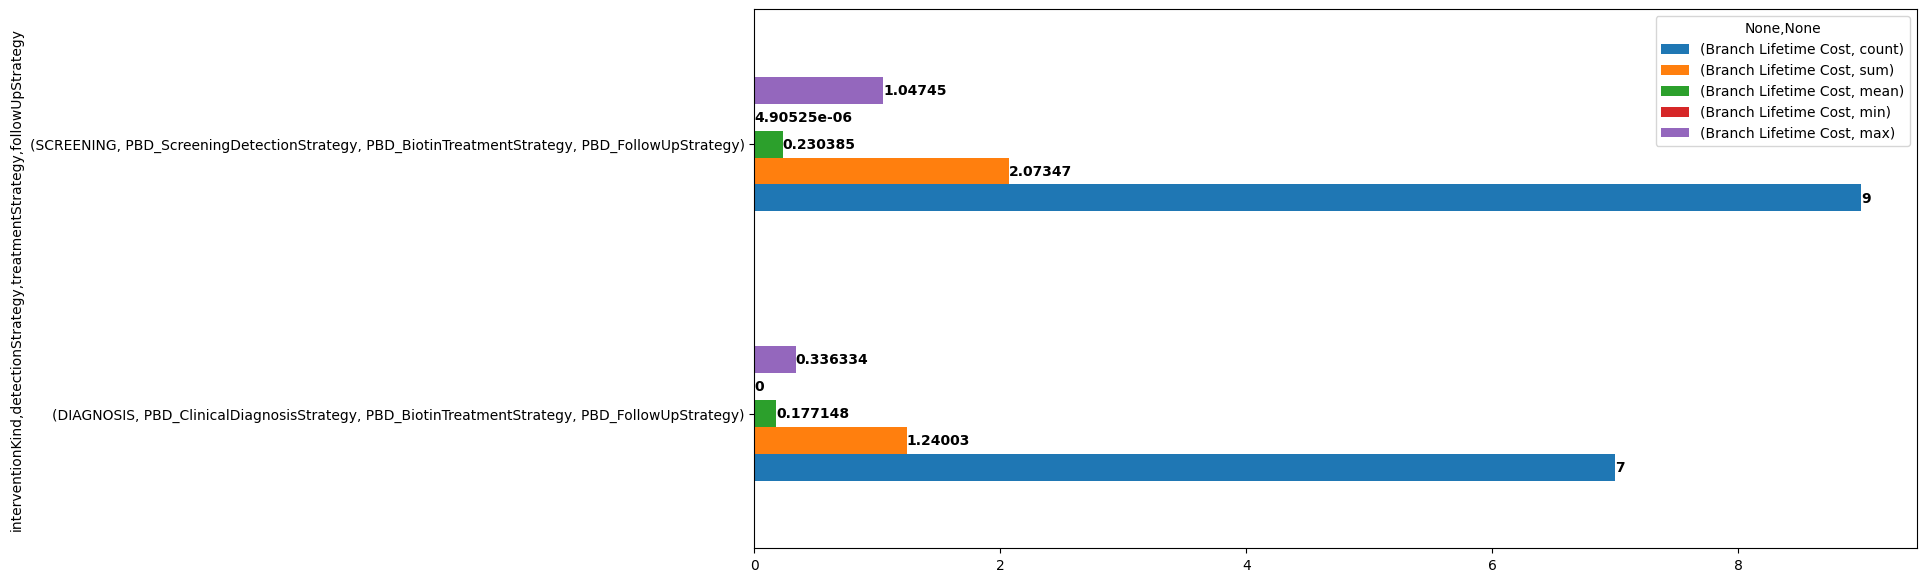

In [31]:
# Specific groupings we want from the data
grouped_params = ['interventionKind', 'detectionStrategy', 'treatmentStrategy', 'followUpStrategy']
# Column of the cost-effective analysis to be analyzed
data_to_display = 'Branch Lifetime Cost'
# Quantitative values to be compared for the different groupings
params_to_display = ['count','sum', 'mean', 'min', 'max']

# We can see the table of groupings to verify its confection
# ceDataframe.groupby(groupedParameters).describe()

# Bar chart to compare the desired parameters of the different groupings
fig, ax = plt.subplots(figsize=(15,7))
diagram = ce_dataframe.groupby(grouped_params).agg({data_to_display: params_to_display})
diagram.plot.barh(ax=ax)

for bars in ax.containers:
    ax.bar_label(bars, fontweight = 'bold')
#plt.xticks(rotation=45, ha='right')

* We can visualize the CE analysis stucture represented by our table in tree form.

In [ ]:
diagnosisDictionary = {'Disease':
        { 'Development':
            {'Intervention':
                {'Has Disease':
                    {
                        'Manifestation_1':{},
                        'Manifestation_N':{}
                    },
                'No Disease':
                    {
                    }     
                }
            }
        }
}

screeningDictionary = {'Disease':
        {'Development':
            {'Intervention':
                {'Has Disease':
                    {
                        'True Positive':{},
                        'False Negative':
                        {
                            'Manifestation_1':{},
                            'Manifestation_N':{}
                        },
                    },
                'No Disease':
                    {
                        'True Negative':{},
                        'False Positive':{}
                    }     
                }
            }
        }     
}

def draw(parent_name, graph, child_name):
    edge = pydot.Edge(parent_name, child_name)
    graph.add_edge(edge)
    
def visit(node, graph, parent=None):
    for k,v in node.items():
        if isinstance(v, dict):
            # We start with the root node whose parent is None
            # we don't want to graph the None node
            if parent:
                draw(parent, graph, k)
            visit(v, graph, k)
        else:
            draw(parent, graph, k)
            # Drawing the label using a distinct name
            draw(k, graph,  k+'_'+v)

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

#graph = pydot.Dot(graph_type='graph')
#visit(screeningDictionary)
#graph.write_png('example1_graph.png')
#diagnosisDictionary['PBD_ProfoundBiotinidaseDeficiency'] = diagnosisDictionary.pop('Disease')
screening_graph = pydot.Dot(graph_type='digraph')
visit(screeningDictionary, screening_graph)
diagnosis_graph = pydot.Dot(graph_type='digraph')
visit(diagnosisDictionary, diagnosis_graph)
#graph.write_png('example1_graph.png')

view_pydot(screening_graph)
view_pydot(diagnosis_graph)


---



---



---

* We can export the results of the cost-benefit analysis to the most convenient format to continue with the inference.

In [ ]:
# Export and download in XLSX format
%pip install openpyxl

destinyPath = 'C:/Users/storh/Downloads/output.xlsx'
ce_dataframe.to_excel(destinyPath, index=False)

In [ ]:
# Export and download in JSON format
destinyPath = 'C:/Users/storh/Downloads/output.json'
ce_dataframe.to_json(destinyPath)

In [ ]:
# Export and download in CSV format
destinyPath = 'C:/Users/storh/Downloads/output.csv'
ce_dataframe.to_csv(destinyPath,  index=False, header=True)

In [ ]:
# Export and download in HTML format
destinyPath = 'C:/Users/storh/Downloads/output.html'
ce_dataframe.to_html(destinyPath)